# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing, model_selection
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, GlobalAveragePooling1D, Dense, Activation, Dropout, BatchNormalization, ReLU 
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Loading and Preprocessing the Data

In [12]:
df=pd.read_csv('EEG_data.csv')
data = pd.read_csv('demographic_info.csv')

In [13]:
data = data.rename(columns = {'subject ID': 'SubjectID'})
df = df.merge(data,how = 'inner',on = 'SubjectID')
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


In [14]:
Data = df.copy()

In [15]:
Data.pop('SubjectID')
Data.pop('VideoID')
Data.pop('predefinedlabel')
Data.pop('user-definedlabeln')
Data.pop(' age')
Data.pop(' ethnicity')
Data.pop(' gender')
Data

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0
...,...,...,...,...,...,...,...,...,...,...,...
12806,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0
12807,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0
12808,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0
12809,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0


Normalizing

In [16]:
Data["Attention"] = Data["Attention"] / Data["Attention"].abs().max()
Data["Mediation"] = Data["Mediation"] / Data["Mediation"].abs().max()
Data["Raw"] = Data["Raw"] / Data["Raw"].abs().max()

In [17]:
x = np.array(Data)
y = np.array(df['user-definedlabeln'])

Splitting

In [18]:
x_train = x[:10000, :]
y_train = y[:10000]
x_val = x[10000:11405, :]
y_val = y[10000:11405]
x_test = x[11405:, :]
y_test = y[11405:]

In [19]:
train = timeseries_dataset_from_array(x_train, sequence_length=1, batch_size=64, targets=y_train)
test = timeseries_dataset_from_array(x_test, sequence_length=1, targets=y_test)
val = timeseries_dataset_from_array(x_val, sequence_length=1, targets=y_val)

# Implementing the Network and Training

In [20]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.1))
model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(1, activation="sigmoid"))

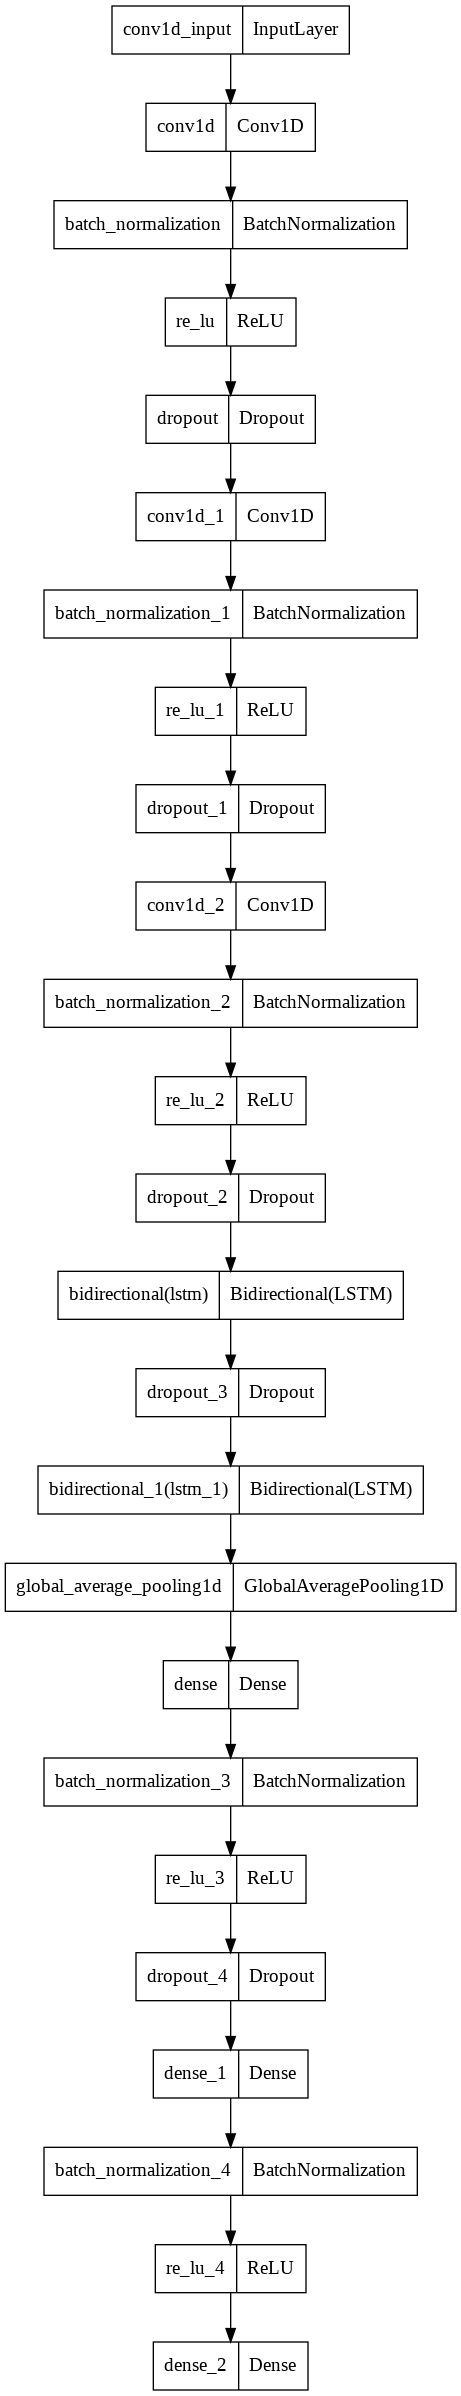

In [28]:
tf.keras.utils.plot_model(model)

In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 4))

In [23]:
model.compile(optimizer=SGD(learning_rate=1e-8, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])

First we will find the optimal Learning Rate

In [25]:
history = model.fit(train, epochs=25, callbacks=[lr_schedule])

Epoch 1/25
157/157 [==============================] - 19s 19ms/step - loss: 0.9937 - accuracy: 0.4615 - lr: 1.0000e-08
Epoch 2/25
157/157 [==============================] - 3s 19ms/step - loss: 0.9939 - accuracy: 0.4625 - lr: 1.7783e-08
Epoch 3/25
157/157 [==============================] - 3s 18ms/step - loss: 0.9947 - accuracy: 0.4587 - lr: 3.1623e-08
Epoch 4/25
157/157 [==============================] - 3s 18ms/step - loss: 0.9921 - accuracy: 0.4599 - lr: 5.6234e-08
Epoch 5/25
157/157 [==============================] - 3s 19ms/step - loss: 0.9924 - accuracy: 0.4618 - lr: 1.0000e-07
Epoch 6/25
157/157 [==============================] - 3s 18ms/step - loss: 0.9938 - accuracy: 0.4618 - lr: 1.7783e-07
Epoch 7/25
157/157 [==============================] - 3s 18ms/step - loss: 0.9928 - accuracy: 0.4607 - lr: 3.1623e-07
Epoch 8/25
157/157 [==============================] - 3s 18ms/step - loss: 0.9923 - accuracy: 0.4624 - lr: 5.6234e-07
Epoch 9/25
157/157 [==============================] - 3

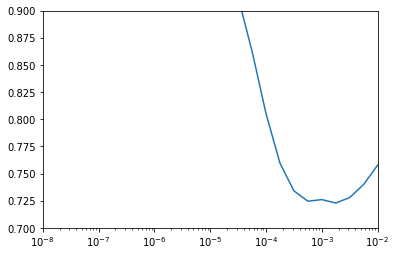

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 0.01, 0.7, 0.9])
plt.show()

In [32]:
model.compile(optimizer=SGD(learning_rate=5.6e-4, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])

In [33]:
history = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
157/157 [==============================] - 11s 30ms/step - loss: 0.7271 - accuracy: 0.5402 - val_loss: 0.8121 - val_accuracy: 0.2776
Epoch 2/100
157/157 [==============================] - 3s 19ms/step - loss: 0.7050 - accuracy: 0.5344 - val_loss: 0.7800 - val_accuracy: 0.2776
Epoch 3/100
157/157 [==============================] - 3s 20ms/step - loss: 0.7017 - accuracy: 0.5353 - val_loss: 0.7711 - val_accuracy: 0.2776
Epoch 4/100
157/157 [==============================] - 3s 19ms/step - loss: 0.7018 - accuracy: 0.5306 - val_loss: 0.7669 - val_accuracy: 0.2776
Epoch 5/100
157/157 [==============================] - 3s 19ms/step - loss: 0.7015 - accuracy: 0.5291 - val_loss: 0.7643 - val_accuracy: 0.2776
Epoch 6/100
157/157 [==============================] - 3s 19ms/step - loss: 0.7000 - accuracy: 0.5320 - val_loss: 0.7627 - val_accuracy: 0.2776
Epoch 7/100
157/157 [==============================] - 3s 20ms/step - loss: 0.7002 - accuracy: 0.5325 - val_loss: 0.7613 - val_accuracy

We will train more

In [37]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-11 * 10**(epoch / 4))
model.compile(optimizer=SGD(learning_rate=1e-11, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])
history2 = model.fit(train, epochs=25, callbacks=[lr_schedule])

Epoch 1/25
157/157 [==============================] - 9s 18ms/step - loss: 0.6791 - accuracy: 0.5726 - lr: 1.0000e-11
Epoch 2/25
157/157 [==============================] - 3s 17ms/step - loss: 0.6747 - accuracy: 0.5730 - lr: 1.7783e-11
Epoch 3/25
157/157 [==============================] - 3s 18ms/step - loss: 0.6753 - accuracy: 0.5693 - lr: 3.1623e-11
Epoch 4/25
157/157 [==============================] - 3s 18ms/step - loss: 0.6764 - accuracy: 0.5831 - lr: 5.6234e-11
Epoch 5/25
157/157 [==============================] - 3s 17ms/step - loss: 0.6757 - accuracy: 0.5749 - lr: 1.0000e-10
Epoch 6/25
157/157 [==============================] - 3s 18ms/step - loss: 0.6740 - accuracy: 0.5893 - lr: 1.7783e-10
Epoch 7/25
157/157 [==============================] - 3s 17ms/step - loss: 0.6761 - accuracy: 0.5810 - lr: 3.1623e-10
Epoch 8/25
157/157 [==============================] - 3s 17ms/step - loss: 0.6771 - accuracy: 0.5809 - lr: 5.6234e-10
Epoch 9/25
157/157 [==============================] - 3s

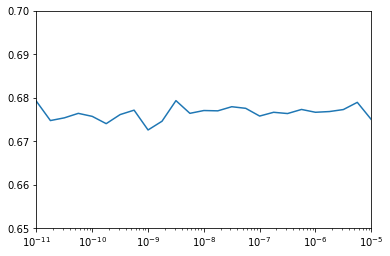

In [40]:
plt.semilogx(history2.history["lr"], history2.history["loss"])
plt.axis([1e-11, 1e-5, 0.65, 0.7])
plt.show()

In [41]:
model.compile(optimizer=SGD(learning_rate=1e-9, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])
history2 = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
157/157 [==============================] - 11s 27ms/step - loss: 0.6769 - accuracy: 0.5646 - val_loss: 0.7332 - val_accuracy: 0.3936
Epoch 2/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6748 - accuracy: 0.5824 - val_loss: 0.7347 - val_accuracy: 0.3907
Epoch 3/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6758 - accuracy: 0.5784 - val_loss: 0.7346 - val_accuracy: 0.3915
Epoch 4/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6741 - accuracy: 0.5818 - val_loss: 0.7350 - val_accuracy: 0.3900
Epoch 5/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6770 - accuracy: 0.5768 - val_loss: 0.7340 - val_accuracy: 0.3922
Epoch 6/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6776 - accuracy: 0.5748 - val_loss: 0.7329 - val_accuracy: 0.3943
Epoch 7/100
157/157 [==============================] - 3s 20ms/step - loss: 0.6764 - accuracy: 0.5857 - val_loss: 0.7322 - val_accuracy

# Evaluation

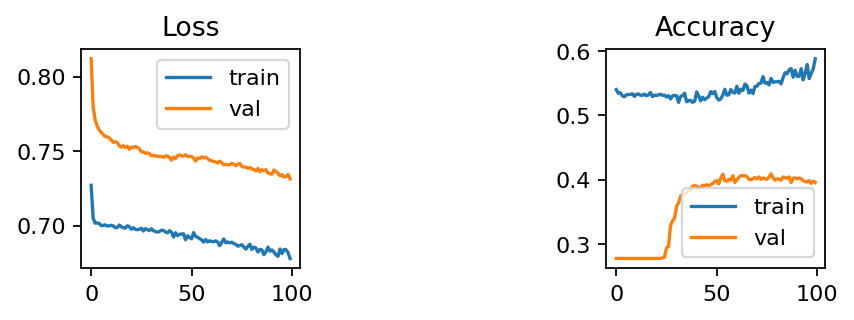

In [34]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

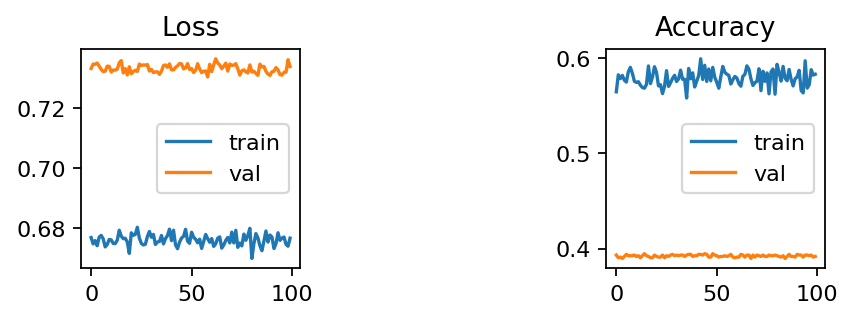

In [42]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [43]:
y_hat = model.predict(test)

11/11 [==============================] - 2s 19ms/step


In [44]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.5241820768136558
Accuracy:  0.5241820768136558
Precision:  0.5241820768136558
Recall:  0.5241820768136558
Confusion Matrix: 



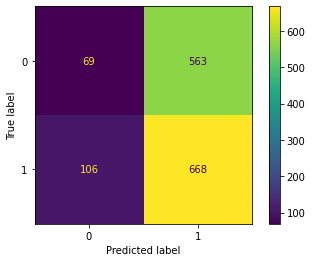

In [45]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()